In [1]:
import pandas as pd
from scipy import sparse
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from nltk.tokenize import wordpunct_tokenize
from sklearn.linear_model import LogisticRegression
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import re
import string

### Inserting fake and real dataset

In [2]:
df = pd.read_csv("train.csv") 
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


## Preprocessed Text

In [3]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') 
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emabaranauskaite/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

def preprocess(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)   
    return lemmatizer.lemmatize(text)

In [5]:
df["title"] = df["title"].fillna('')
df["author"] = df["author"].fillna('')
df["text"] = df["text"].fillna('')

df["article"] = df["title"] + " " + df["author"] + " " + df["text"]
df["article"] = df["article"].apply(preprocess)

In [6]:
# text word count
df['word_count'] = df['article'].apply(lambda x: len(str(x).split()))
print(df[df['label']==1]['word_count'].mean()) # fake articles
print(df[df['label']==0]['word_count'].mean()) # reliable articles

653.7655814846826
871.5472224896505


In [7]:
df['Avg_length'] = df["article"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
print(df[df['label'] == 1]['Avg_length'].mean())
print(df[df['label'] == 0]['Avg_length'].mean())

4.8400481759963565
4.764390476688568


## Training

In [8]:
word_count_avg_length = df[["word_count", "Avg_length"]].values 
article = df["article"].values
labels = df['label'].values

In [9]:
models = {}

#### Splitting the dataset into training set and testing set. 

In [10]:
train_info, test_info,  train_article, test_article, train_labels, test_labels = train_test_split(word_count_avg_length, article, labels, test_size=0.2)

In [11]:
vectorization = TfidfVectorizer()
train_article = vectorization.fit_transform(train_article)
test_article = vectorization.transform(test_article)

In [12]:
train_data = sparse.hstack([train_article, train_info])
test_data = sparse.hstack([test_article, test_info])

### 1. Logistic Regression

In [13]:
LR = LogisticRegression()
LR.fit(train_data, train_labels)

/Users/emabaranauskaite/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [14]:
predictionLr = LR.predict(test_data)

In [15]:
LR.score(test_data, test_labels)

0.9418269230769231

In [16]:
models[LR] = LR.score(test_data, test_labels)

In [17]:
print(classification_report(test_labels, predictionLr))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2101
           1       0.94      0.94      0.94      2059

    accuracy                           0.94      4160
   macro avg       0.94      0.94      0.94      4160
weighted avg       0.94      0.94      0.94      4160



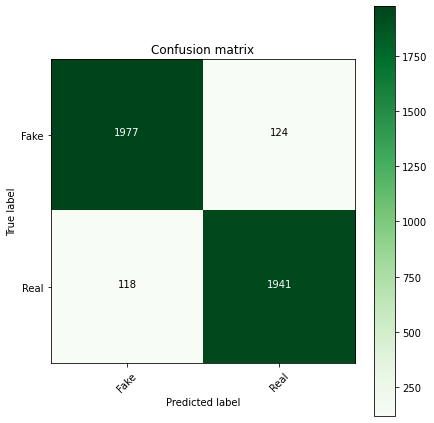

In [18]:
from sklearn import metrics
import itertools

cm = metrics.confusion_matrix(test_labels, predictionLr)

plt.figure(figsize=(6, 6)) 

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion matrix')
plt.colorbar()

plt.xticks(np.arange(len(['Fake', 'Real'])), ['Fake', 'Real'], rotation=45)
plt.yticks(np.arange(len(['Fake', 'Real'])), ['Fake', 'Real'])
 
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [20]:
testdata = pd.read_csv('test.csv')
 
testdata = testdata.fillna('') 

testdata["article"] = testdata["title"] + " " + testdata["author"] + " " + testdata["text"]
testdata['article'] = testdata['article'].apply(preprocess) 

testdata['word_count'] = testdata['article'].apply(lambda x: len(str(x).split()))
testdata['Avg_length'] = testdata["article"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

wordCount_avgLength = testdata[["word_count", "Avg_length"]].values

testdatavalues = testdata['article'].values  
testdatavalues = vectorization.transform(testdatavalues)

newcontent = sparse.hstack([testdatavalues, wordCount_avgLength])
testdata['label'] = LR.predict(newcontent)

newdf = pd.DataFrame()
newdf["id"] = testdata["id"]
newdf["label"] = testdata["label"]  
display(newdf)

newdf.to_csv('submit.csv', index=False)

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1
...,...,...
5195,25995,1
5196,25996,0
5197,25997,0
5198,25998,1


### 2. Decision Tree Classification

In [21]:
from sklearn.tree import DecisionTreeClassifier

In [22]:
DT = DecisionTreeClassifier()
DT.fit(train_data, train_labels)

DecisionTreeClassifier()

In [23]:
predictionDT = DT.predict(test_data)

In [24]:
DT.score(test_data, test_labels)

0.9663461538461539

In [25]:
models[DT] = DT.score(test_data, test_labels)

In [26]:
print(classification_report(test_labels, predictionDT))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2101
           1       0.96      0.97      0.97      2059

    accuracy                           0.97      4160
   macro avg       0.97      0.97      0.97      4160
weighted avg       0.97      0.97      0.97      4160



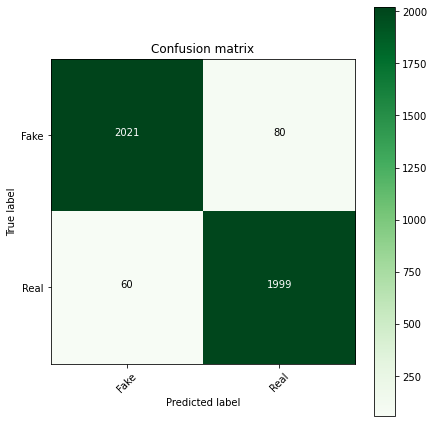

In [27]:
from sklearn import metrics
import itertools

cm = metrics.confusion_matrix(test_labels, predictionDT)

plt.figure(figsize=(6, 6)) 

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion matrix')
plt.colorbar()

plt.xticks(np.arange(len(['Fake', 'Real'])), ['Fake', 'Real'], rotation=45)
plt.yticks(np.arange(len(['Fake', 'Real'])), ['Fake', 'Real'])
 
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Testing on test data

In [ ]:
testdata = pd.read_csv('test.csv')
 
testdata = testdata.fillna('') 

testdata["article"] = testdata["title"] + " " + testdata["author"] + " " + testdata["text"]
testdata['article'] = testdata['article'].apply(preprocess) 

testdata['word_count'] = testdata['article'].apply(lambda x: len(str(x).split()))
testdata['Avg_length'] = testdata["article"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

wordCount_avgLength = testdata[["word_count", "Avg_length"]].values

testdatavalues = testdata['article'].values  
testdatavalues = vectorization.transform(testdatavalues)

newcontent = sparse.hstack([testdatavalues, wordCount_avgLength])
testdata['label'] = DT.predict(newcontent)

newdf = pd.DataFrame()
newdf["id"] = testdata["id"]
newdf["label"] = testdata["label"]  
display(newdf)

newdf.to_csv('submit.csv', index=False)